# Problem Set #7
MACS 30150, Dr. Evans  
Minghao Yang

In [1]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error
from scipy.interpolate import LSQUnivariateSpline
import numpy as np

## 1. Multinomial logistic regression and cross validation (6 points)
### (a)

In [2]:
# Load the data as a dataframe
df1 = pd.read_csv('data/strongdrink.txt')
df1.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
# Check if there are missing values
df1.isnull().sum()

cultivar      0
alco          0
malic         0
ash           0
alk           0
magn          0
tot_phen      0
flav          0
nonfl_phen    0
proanth       0
color_int     0
hue           0
OD280rat      0
proline       0
dtype: int64

In [4]:
# Sample splitting
X_1a = df1[['alco', 'malic', 'tot_phen', 'color_int']]
y_1a = df1['cultivar']
X_train_1a, X_test_1a, y_train_1a, y_test_1a = train_test_split(X_1a, y_1a, test_size=0.25, random_state=20)

In [5]:
# Multinomial logit regression
print(np.unique(y_train_1a, return_counts=True))
print(X_train_1a.shape)
clf_1a = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000).fit(X_train_1a, y_train_1a)
print(clf_1a.intercept_)
print(clf_1a.coef_)

(array([1, 2, 3], dtype=int64), array([46, 50, 36], dtype=int64))
(132, 4)
[-24.02761653  22.7807325    1.24688403]
[[ 1.70173443 -0.26578756  1.22410094  0.02250699]
 [-1.46629729 -0.33295144  0.66355615 -0.92268168]
 [-0.23543714  0.598739   -1.88765709  0.90017469]]


The coefficients from the above multinomial logit regression are as follow: 

| Coefficient | <center>$j = 1$</center> | <center>$j = 2$</center> |   
| ---- | ----- | ----- |  
| <center>$\beta_0$</center> | <center>$-24.03$</center> | <center>$22.78$</center> |  
| <center>$\beta_1$</center> | <center>$1.70$</center> | <center>$-1.47$</center> |  
| <center>$\beta_2$</center> | <center>$-0.27$</center> | <center>$-0.33$</center> |  
| <center>$\beta_3$</center> | <center>$1.22$</center> | <center>$0.66$</center> |  
| <center>$\beta_4$</center> | <center>$0.02$</center> | <center>$-0.92$</center> |  

In [6]:
# Report the error rates
y_pred_1a = clf_1a.predict(X_test_1a)
print(classification_report(y_test_1a, y_pred_1a))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



In [7]:
# Calculate the MSE
print('Validation set MSE =', mean_squared_error(y_test_1a, y_pred_1a))

Validation set MSE = 0.045454545454545456


The error rates are 13\%, 0\%, and 0\%, respectively. Although $j = 2$ and $j = 3$ have the same error rate, while $j = 3$ has a higher F1 score, so the model predicts $j = 3$ the best. Given that there are 46 observations with $j = 1$, 50 observations with $j = 2$, and 36 observations with $j = 3$, the most accurately predicted category in fact has the least observations. The corresponding MSE is 0.045.

### (b)

In [8]:
# Generate dependent variables and independent variables and set basic parameters
Xvars_1b = X_1a.values
yvars_1b = y_1a.values
N_loo_1b = Xvars_1b.shape[0]
loo_1b = LeaveOneOut()
loo_1b.get_n_splits(Xvars_1b)
MSE_vec_1b = np.zeros(N_loo_1b)
y_test_vec_1b = np.zeros(N_loo_1b)
y_pred_vec_1b = np.zeros(N_loo_1b)

# Calculate the MSE by loop
for train_index, test_index in loo_1b.split(Xvars_1b):
    X_train_1b, X_test_1b = Xvars_1b[train_index], Xvars_1b[test_index]
    y_train_1b, y_test_1b = yvars_1b[train_index], yvars_1b[test_index]
    clf_1b = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
    clf_1b.fit(X_train_1b, y_train_1b)
    y_pred_1b = clf_1b.predict(X_test_1b)
    MSE_vec_1b[test_index] = (1 - (y_test_1b == y_pred_1b))
    y_test_vec_1b[test_index] = y_test_1b
    y_pred_vec_1b[test_index] = y_pred_1b
    # print('MSE for test set', test_index, ' is', MSE_vec[test_index])

print(classification_report(y_test_vec_1b, y_pred_vec_1b))
MSE_loo_1b = MSE_vec_1b.mean()
MSE_loo_std_1b = MSE_vec_1b.std()
print('The LOOCV estimate for the test MSE =', MSE_loo_1b)
print('The LOOCV estimate for the test MSE standard err =', MSE_loo_std_1b)

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.92        59
         2.0       0.91      0.90      0.91        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176

The LOOCV estimate for the test MSE = 0.07954545454545454
The LOOCV estimate for the test MSE standard err = 0.2705882022679695


The error rates are 10\%, 9\%, and 4\%, respectively. Compared with part (a), the error rate for $j = 1$ becomes smaller, while the error rates for $j = 2$ and $j = 3$ become larger. The LOOCV estimate for the test MSE is 0.080.

### (c)

In [9]:
# Set basic parameters
kf_1c = KFold(n_splits=4, random_state=10, shuffle=True)
kf_1c.get_n_splits(Xvars_1b)
MSE_vec_1c = np.zeros(4)
y_test_vec_1c = np.array([])
y_pred_vec_1c = np.array([])
k_ind = int(0)

# Calculate the MSE by loop
for train_index, test_index in kf_1c.split(Xvars_1b):
    # print("TRAIN:", train_index, "TEST:", test_index)
    # print('k index=', k_ind)
    X_train_1c, X_test_1c = Xvars_1b[train_index], Xvars_1b[test_index]
    y_train_1c, y_test_1c = yvars_1b[train_index], yvars_1b[test_index]
    clf_1c = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
    clf_1c.fit(X_train_1c, y_train_1c)
    y_pred_1c = clf_1c.predict(X_test_1c)
    MSE_vec_1c[k_ind] =(1 - (y_test_1c == y_pred_1c)).mean()
    y_test_vec_1c = np.append(y_test_vec_1c, y_test_1c)
    y_pred_vec_1c = np.append(y_pred_vec_1c, y_pred_1c)
    # print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

print(classification_report(y_test_vec_1c, y_pred_vec_1c))
MSE_kf_1c = MSE_vec_1c.mean()
MSE_kf_std_1c = MSE_vec_1c.std()
print('The K-fold estimate for the test MSE =', MSE_kf_1c)
print('The K-fold estimate for the test MSE standard err =', MSE_kf_std_1c)

              precision    recall  f1-score   support

         1.0       0.87      0.93      0.90        59
         2.0       0.91      0.87      0.89        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176

The K-fold estimate for the test MSE = 0.09090909090909091
The K-fold estimate for the test MSE standard err = 0.04821182598999188


The error rates are 13\%, 9\%, and 4\%, respectively. Compared with part (a), the error rate for $j = 1$ remains the same, while the error rates for $j = 2$ and $j = 3$ become larger. Compared with part (b), the error rate for $j = 1$ becomes larger, while the error rates for $j = 2$ and $j = 3$ remain the same. The k-fold estimate for the test MSE is 0.091.

## 2. Splines and interpolation (4 points)

### (a)

In [10]:
# Load the data as a dataframe
df2 = pd.read_csv('data/CoolIndex.txt', names=['age', 'cool_index'])
df2.head()

,age,cool_index
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


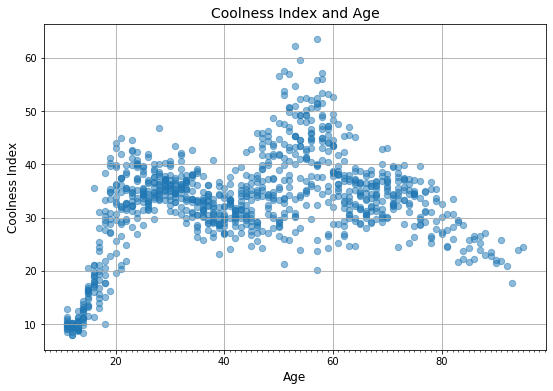

In [11]:
# Draw the scatterplot
plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.scatter(df2['age'], df2['cool_index'], s=40, marker='o', alpha=0.5, label='Data')
minorLocator = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(b=True, which='major', color='0.65', linestyle='-')
ax.set_xlabel(r'Age', size=12)
ax.set_ylabel(r'Coolness Index', size=12)
ax.set_title(r'Coolness Index and Age', size=14)
plt.show()

### (b)

In [12]:
# Generate 5 bins
df2['age_bin1'] = ((df2['age'] >= 11) & (df2['age'] < 22)).astype('int32')
df2['age_bin2'] = ((df2['age'] >= 22) & (df2['age'] < 40)).astype('int32')
df2['age_bin3'] = ((df2['age'] >= 40) & (df2['age'] < 59)).astype('int32')
df2['age_bin4'] = ((df2['age'] >= 59) & (df2['age'] < 77)).astype('int32')
df2['age_bin5'] = ((df2['age'] >= 77) & (df2['age'] <= 95)).astype('int32')

In [13]:
# OLS fit
X_2b = df2[['age_bin1', 'age_bin2', 'age_bin3', 'age_bin4', 'age_bin5']]
y_2b = df2['cool_index']
results_2b = sm.OLS(y_2b, X_2b).fit()
print(results_2b.summary())

                            OLS Regression Results                            
Dep. Variable:             cool_index   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Mon, 24 Feb 2020   Prob (F-statistic):          3.73e-114
Time:                        18:00:08   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.562     35.746      0.0

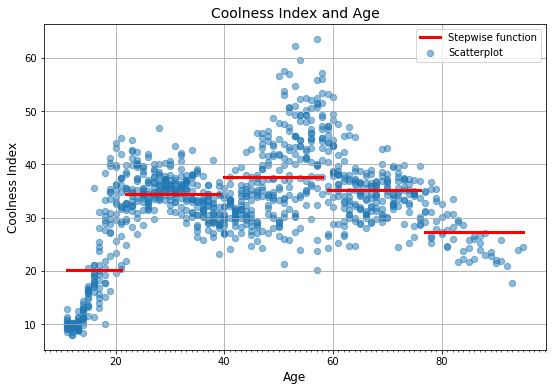

In [14]:
# Draw the plot
plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.scatter(df2['age'], df2['cool_index'], s=40, marker='o', alpha=0.5, label='Scatterplot')
ax.plot(range(11, 22), [results_2b.predict([1, 0, 0, 0, 0]) for i in range(11, 22)], 
        color='r', linewidth=3, label='Stepwise function')
ax.plot(range(22, 40), [results_2b.predict([0, 1, 0, 0, 0]) for i in range(22, 40)], 
        color='r', linewidth=3,)
ax.plot(range(40, 59), [results_2b.predict([0, 0, 1, 0, 0]) for i in range(40, 59)], 
        color='r', linewidth=3,)
ax.plot(range(59, 77), [results_2b.predict([0, 0, 0, 1, 0]) for i in range(59, 77)], 
        color='r', linewidth=3,)
ax.plot(range(77, 96), [results_2b.predict([0, 0, 0, 0, 1]) for i in range(77, 96)], 
        color='r', linewidth=3,)
minorLocator = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(b=True, which='major', color='0.65', linestyle='-')
ax.set_xlabel(r'Age', size=12)
ax.set_ylabel(r'Coolness Index', size=12)
ax.set_title(r'Coolness Index and Age', size=14)
ax.legend()
plt.show()

In [15]:
# Predict the coolness index for a 73-year-old individual
results_2b.predict([0, 0, 0, 1, 0])

array([35.22540004])

The coefficients of the regression is as follow:  

| <center>Coefficient</center> | <center>Value</center> |  
| --- | ---- |  
| <center>$\beta_1$</center> | <center>$20.1025$</center> |  
| <center>$\beta_2$</center> | <center>$34.4758$</center> | 
| <center>$\beta_3$</center> | <center>$37.6351$</center> | 
| <center>$\beta_4$</center> | <center>$35.2254$</center> | 
| <center>$\beta_5$</center> | <center>$27.2964$</center> | 

The predicted coolness index of a 73-year-old individual from the stepwise function is 35.23.

### (c)

In [16]:
# Group and index the dataframe by age
df2_group = df2.groupby('age').mean()
df2_group['age'] = df2_group.index
df2_group[['age', 'cool_index']].head()

,age,cool_index
age,,
11.0,11.0,10.110237
12.0,12.0,9.365623
13.0,13.0,10.015882
14.0,14.0,11.747109
15.0,15.0,15.434739


In [17]:
# Fit a linear spline
ls_2c = LSQUnivariateSpline(np.array(df2_group['age']), 
                            np.array(df2_group['cool_index']), 
                            t=[22, 40, 59, 77], k=1)

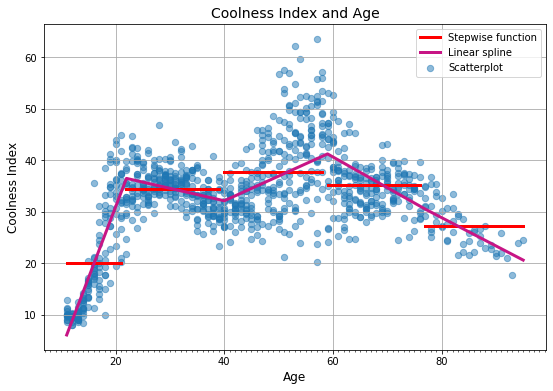

In [18]:
# Draw the plot
plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.scatter(df2['age'], df2['cool_index'], s=40, marker='o', alpha=0.5, label='Scatterplot')
ax.plot(range(11, 22), [results_2b.predict([1, 0, 0, 0, 0]) for i in range(11, 22)], 
        color='r', linewidth=3, label='Stepwise function')
ax.plot(range(22, 40), [results_2b.predict([0, 1, 0, 0, 0]) for i in range(22, 40)], 
        color='r', linewidth=3)
ax.plot(range(40, 59), [results_2b.predict([0, 0, 1, 0, 0]) for i in range(40, 59)], 
        color='r', linewidth=3)
ax.plot(range(59, 77), [results_2b.predict([0, 0, 0, 1, 0]) for i in range(59, 77)], 
        color='r', linewidth=3)
ax.plot(range(77, 96), [results_2b.predict([0, 0, 0, 0, 1]) for i in range(77, 96)], 
        color='r', linewidth=3)
ax.plot(df2_group['age'], ls_2c(df2_group['age']), color='mediumvioletred', linewidth=3, label='Linear spline')
minorLocator = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(b=True, which='major', color='0.65', linestyle='-')
ax.set_xlabel(r'Age', size=12)
ax.set_ylabel(r'Coolness Index', size=12)
ax.set_title(r'Coolness Index and Age', size=14)
ax.legend()
plt.show()

In [19]:
# Predict the coolness index for a 73-year-old individual
ls_2c(73)

array(32.86784862)

The predicted coolness index of a 73-year-old individual from the linear spline is 32.87.

### (d)

In [20]:
# Fit a cubic spline
cs_2d = LSQUnivariateSpline(np.array(df2_group['age']), 
                            np.array(df2_group['cool_index']), 
                            t=[22, 40, 59, 77], k=3)

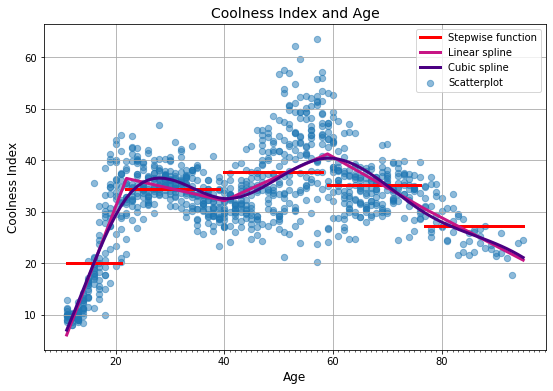

In [21]:
# Draw the plot
plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.scatter(df2['age'], df2['cool_index'], s=40, marker='o', alpha=0.5, label='Scatterplot')
ax.plot(range(11, 22), [results_2b.predict([1, 0, 0, 0, 0]) for i in range(11, 22)], 
        color='r', linewidth=3, label='Stepwise function')
ax.plot(range(22, 40), [results_2b.predict([0, 1, 0, 0, 0]) for i in range(22, 40)], 
        color='r', linewidth=3)
ax.plot(range(40, 59), [results_2b.predict([0, 0, 1, 0, 0]) for i in range(40, 59)], 
        color='r', linewidth=3)
ax.plot(range(59, 77), [results_2b.predict([0, 0, 0, 1, 0]) for i in range(59, 77)], 
        color='r', linewidth=3)
ax.plot(range(77, 96), [results_2b.predict([0, 0, 0, 0, 1]) for i in range(77, 96)], 
        color='r', linewidth=3)
ax.plot(df2_group['age'], ls_2c(df2_group['age']), color='mediumvioletred', linewidth=3, label='Linear spline')
ax.plot(df2_group['age'], cs_2d(df2_group['age']), color='indigo', linewidth=3, label='Cubic spline')
minorLocator = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(b=True, which='major', color='0.65', linestyle='-')
ax.set_xlabel(r'Age', size=12)
ax.set_ylabel(r'Coolness Index', size=12)
ax.set_title(r'Coolness Index and Age', size=14)
ax.legend()
plt.show()

In [22]:
# Predict the coolness index for a 73-year-old individual
cs_2d(73)

array(32.64230107)

The predicted coolness index of a 73-year-old individual from the cubic spline is 32.64.